# Adversarial Patch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import random

device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cpu":
    device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
print("device:", device)

device: cuda


## Dataset

In [2]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010) )  # Normalize the images
])
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)

test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


## Train image classifer model

### Hyperparameters for training models

In [3]:
from torchvision import models

# initial learning rate
INITIAL_LR = 0.001

# momentum for optimizer
MOMENTUM = 0.9

# L2 regularization strength
REG = 1e-3

# total number of training epochs
EPOCHS = 5

# number of epochs before decay learning rate 
DECAY_EPOCHS = 5

# rate of decay for learning rate
DECAY = 0.1

# the folder where the trained model is saved
CHECKPOINT_FOLDER = "./saved_model"

num_classes = 10  # Number of classes in CIFAR-10

# ResNet-50 model
# model = models.resnet50(pretrained=True)  # Initialize ResNet-50 model
# model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Modify output layer to match number of classes
# model = model.to(device)

# VGG16
# model = models.vgg16(pretrained = True)
# model.classifier[6] = nn.Linear(model.classifier[6].in_features,num_classes)
# model = model.to(device)

# DenseNet model
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# create loss function
criterion = nn.CrossEntropyLoss()

# Add optimizer
optimizer = optim.SGD(model.parameters(), lr=INITIAL_LR, momentum=MOMENTUM, weight_decay=REG)


c:\Users\xiong\miniforge3\envs\ECE661\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xiong\miniforge3\envs\ECE661\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Train model

In [4]:
import os
from tqdm import tqdm

# Train CNN models
train_loader = DataLoader(
    train_dataset,
    batch_size=64, shuffle=True
)
# start the training/validation process
best_acc = 0
current_learning_rate = INITIAL_LR

print("==> Training starts!")
print("="*50)
for i in range(0, EPOCHS):
    # handle the learning rate scheduler.
    if i % DECAY_EPOCHS == 0 and i != 0:
        current_learning_rate = current_learning_rate * DECAY
        for param_group in optimizer.param_groups:
            param_group['lr'] = current_learning_rate
        print("Current learning rate has decayed to %f" %current_learning_rate)
    
    #######################
    # switch to train mode
    model.train()
    
    #######################
    
    print("Epoch %d:" %i)
    # this help you compute the training accuracy
    total_examples = 0
    correct_examples = 0

    train_loss = 0 # track training loss if you want
    
    # Train the model for 1 epoch.
    with tqdm(train_loader, unit="batch") as t:
        for batch_idx, (inputs, targets) in enumerate(t):
            ####################################
            # copy inputs to device
            inputs = inputs.to(device)
            targets = targets.to(device)
            
            # compute the output and loss
            outputs = model(inputs)
            loss = criterion(outputs, targets.long())
            train_loss += loss.item()
            
            # zero the gradient
            optimizer.zero_grad()
            
            # backpropagation
            loss.backward()
            
            # apply gradient and update the weights
            optimizer.step()
            
            # count the number of correctly predicted samples in the current batch
            _, predicted = torch.max(outputs.data, 1)
            correct_examples += (predicted == targets).sum().item()
            total_examples += inputs.shape[0]
            ####################################
            t.set_description(f"Epoch {i}: Training")
            t.set_postfix(train_loss=train_loss / len(train_loader))
                
    avg_loss = train_loss / len(train_loader)
    avg_acc = correct_examples / total_examples
    print("Training loss: %.4f, Training accuracy: %.4f" %(avg_loss, avg_acc))
    
    # save the model checkpoint
    if avg_acc > best_acc: 
        best_acc = avg_acc
        if not os.path.exists(CHECKPOINT_FOLDER):
            os.makedirs(CHECKPOINT_FOLDER)
        print("Saving ...")
        state = {'state_dict': model.state_dict(),
                 'epoch': i,
                 'lr': current_learning_rate}
        torch.save(state, os.path.join(CHECKPOINT_FOLDER, 'resnet50.pth'))
        
print("="*50)
print(f"==> Optimization finished! Best training accuracy: {best_acc:.4f}")

Couldn't find program: 'false'


### Evaluate model test accuracy

In [5]:
def test_model(mdl, loader, device):
    mdl.eval()
    running_correct = 0.
    running_loss = 0.
    running_total = 0.
    with torch.no_grad():
        for batch_idx,(data,labels) in enumerate(loader):
            data = data.to(device); labels = labels.to(device)
            clean_outputs = mdl(data)
            clean_loss = F.cross_entropy(clean_outputs, labels)
            _,clean_preds = clean_outputs.max(1)
            running_correct += clean_preds.eq(labels).sum().item()
            running_loss += clean_loss.item()
            running_total += labels.size(0)
    clean_acc = running_correct/running_total
    clean_loss = running_loss/len(loader)
    mdl.train()
    return clean_acc,clean_loss

In [6]:
# Test model accuracy
from torchvision import models
import os

test_loader = DataLoader(
    test_dataset,
    batch_size=64, shuffle=False
)

num_classes = 10  # Number of classes in CIFAR-10

# ResNet-50 model
model = models.resnet50(pretrained=True)  # Initialize ResNet-50 model
model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Modify output layer to match number of classes
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'resnet50_.pth'))['state_dict']) 

# VGG16
# model = models.vgg16(pretrained = True)
# model.classifier[6] = nn.Linear(model.classifier[6].in_features,num_classes)
# model = model.to(device)
# model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'vgg16_.pth'))['state_dict']) 


# DenseNet model
# model = models.densenet121(pretrained=True)
# model.classifier = nn.Linear(model.classifier.in_features, num_classes)
# model = model.to(device)
# model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'densenet_.pth'))['state_dict']) 


model.eval()
model.to(device)
test_model(model, test_loader, device)

c:\Users\xiong\miniforge3\envs\ECE661\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


(0.9628, 0.12854603722477984)

## Adversarial patch generation

In [7]:
# util functions for adversarial patch generation
from torchvision.transforms.functional import affine

data_mean_tensor = torch.tensor([0.485, 0.456, 0.406]).to(device)
data_std_tensor = torch.tensor([0.229, 0.224, 0.225]).to(device)

# Apply the adversarial patch on the target image at the given location
def apply_patch(image, patch, patch_size, location=(0, 0)):
    for i in range(image.shape[0]):
        image[i, :, location[0]:location[0]+patch_size, location[1]:location[1]+patch_size] = patch
    return image

# Make random transformation of the patch during training 
def random_transform(patch):
    angle = random.uniform(-22, 22)  # Rotation angle in degrees
    translate = [random.uniform(-0.1 * patch.size(-2), 0.1 * patch.size(-2)), 
                 random.uniform(-0.1 * patch.size(-1), 0.1 * patch.size(-1))]  # Translation
    scale = random.uniform(0.8, 1.2)  # Scaling
    shear = random.uniform(-10, 10)  # Shear

    # Apply affine transformation
    # Ensure that this operation creates a new tensor
    transformed_patch = affine(patch.clone(), angle=angle, translate=translate, scale=scale, shear=shear)

    return transformed_patch

# Compute the gradient of the loss w.r.t. the input data
def gradient_wrt_data(model,device,data,lbl):
    dat = data.clone().detach()
    dat.requires_grad = True
    out = model(dat)
    loss = F.cross_entropy(out,lbl)
    model.zero_grad()
    loss.backward()
    data_grad = dat.grad.data
    return data_grad.data.detach()

In [8]:
# Get a image from a given class
def get_target_image(target_class, target_size, dataloader, dataset):
    for image, label in dataloader:
        if label.item() == target_class:
            image = image.squeeze(0)
            print(image.shape)
            target_image = image
            transform = transforms.Compose([transforms.Resize(target_size)])
            target_image = transform(image)

            plt.figure(figsize=(6, 6))
            plt.imshow(transforms.ToPILImage()(target_image))
            plt.axis('off')
            plt.title(f'Target Image (Class {target_class}):{dataset.classes[target_class]}')
            plt.show()

            break
    return target_image

### Untargeted Adversarial Patch

Epoch 4, Loss: 0.01: 100%|██████████| 5000/5000 [11:00<00:00,  7.57it/s]


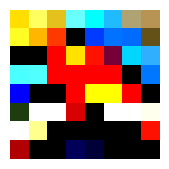

Epoch 4, Loss: 0.00: 100%|██████████| 5000/5000 [11:06<00:00,  7.50it/s] 


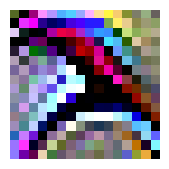

Epoch 4, Loss: 1.14: 100%|██████████| 5000/5000 [11:18<00:00,  7.37it/s] 


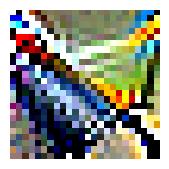

Epoch 4, Loss: 15.09: 100%|██████████| 5000/5000 [11:17<00:00,  7.38it/s]


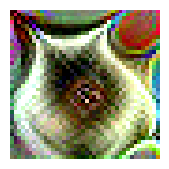

Epoch 4, Loss: 1.01: 100%|██████████| 5000/5000 [16:12<00:00,  5.14it/s] 


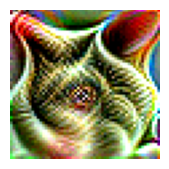

In [12]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm

model.eval()
model.to(device)

# Train data loader
dataloader = DataLoader(
    train_dataset,
    batch_size=1, 
    shuffle=True, 
    num_workers=4
)

data_mean_np = np.array([0.485, 0.456, 0.406])
data_std_np = np.array([0.229, 0.224, 0.225])


# Define the patch size and initialize the patch
for patch_size in [8, 16, 24, 40, 56]:
    # Size of the patch

    # Initialization the patch blank
    patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True) 
    optimizer = torch.optim.SGD([patch], lr=0.01, momentum=0.9)
    loss_fn = nn.NLLLoss()

    num_epochs = 5
    # Smaller number of data per epoch for testing
    num_data = 5000
    lr = 0.1
    # Training loop
    for epoch in range(num_epochs):  
        with tqdm(enumerate(dataloader), total=num_data) as t:
            for i, (img, target) in t:
                if i >= num_data:
                    break

                count = 0
                max_iteration = 10

                # Apply random transformation to the patch
                transformed_patch = random_transform(patch)

                # Move tensors to the device before applying the patch
                img = img.to(device)
                transformed_patch = transformed_patch.to(device)

                # Choose a random location to apply the patch
                location = (random.randint(0, img.shape[2] - patch_size), random.randint(0, img.shape[3] - patch_size))

                while count < max_iteration:

                    count += 1
                    # Apply the transformed patch to the image
                    patched_img = apply_patch(img, transformed_patch, patch_size, location).to(device)

                    # Forward pass
                    output = model(patched_img)
                    log_probs = F.log_softmax(output, dim=1)

                    # Calculate loss
                    labels = torch.zeros(patched_img.shape[0], device=device, dtype=torch.long).fill_(target.item())
                    loss = -loss_fn(log_probs, labels) # Add negative sign to maximize the error

                    optimizer.zero_grad()

                    # Back propergation
                    loss.backward(retain_graph=True)

                    # Update patch
                    optimizer.step()
                    t.set_description(f"Epoch {epoch}, Loss: {-loss.item():4.2f}")

                    # Clamp the patch values to ensure they are within [-3, 3]
                    patch.data = torch.clamp(patch.data, min=-3, max=3)

    # Save the final patch
    final_patch = patch.detach().numpy()
    plt.figure(figsize=(10,5))
    plt.subplot(2,6,1)
    plt.imshow(np.transpose(np.clip(final_patch * data_std_np[:, None, None] + data_mean_np[:, None, None], 0, 1), (1, 2, 0)))
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    np.save(f'patches/adv_patch_untargeted_{patch_size}.npy', final_patch)

### Targeted Adversarial Patch

In [10]:
dataset = datasets.CIFAR10('./data', train=True, download=True, transform=transform)
dataset.classes

Files already downloaded and verified


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Epoch 4, Loss: 6.66: 100%|██████████| 5000/5000 [11:28<00:00,  7.26it/s] 


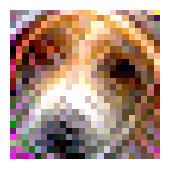

Epoch 4, Loss: 6.76: 100%|██████████| 5000/5000 [05:14<00:00, 15.92it/s] 


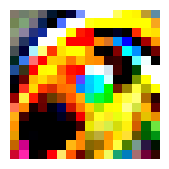

Epoch 4, Loss: 2.72: 100%|██████████| 5000/5000 [03:25<00:00, 24.35it/s] 


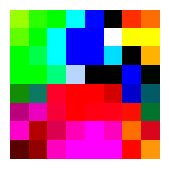

In [14]:
from tqdm import tqdm

model.eval()
model.to(device)

# Train data loader
dataloader = DataLoader(
    train_dataset,
    batch_size=1, 
    shuffle=True, 
    num_workers=4
)

data_mean_np = np.array([0.485, 0.456, 0.406])
data_std_np = np.array([0.229, 0.224, 0.225])

# Choose target class
for c in [5]:
# Define the patch size and initialize the patch
    target_class = torch.tensor([c]).to(device)
    for patch_size in [24,16,8]:
        # Size of the patch

        # Initialization the patch blank
        patch = nn.Parameter(torch.zeros(3, patch_size, patch_size), requires_grad=True) 
        optimizer = torch.optim.SGD([patch], lr=0.01, momentum=0.9)
        loss_fn = nn.NLLLoss()

        num_epochs = 5
        # Smaller number of data per epoch for testing
        num_data = 5000

        # Training loop
        for epoch in range(num_epochs):  
            with tqdm(enumerate(dataloader), total=num_data) as t:
                for i, (img, target) in t:
                    if i >= num_data:
                        break

                    target_prob, count = 0, 0
                    prob_threshold = 0.9
                    max_iteration = 10

                    # Apply random transformation to the patch
                    transformed_patch = random_transform(patch)

                    # Move tensors to the device before applying the patch
                    img = img.to(device)
                    transformed_patch = transformed_patch.to(device)

                    # Choose a random location to apply the patch
                    location = (random.randint(0, img.shape[2] - patch_size), random.randint(0, img.shape[3] - patch_size))

                    while count < max_iteration and target_prob < prob_threshold and target.to(device) != target_class:

                        count += 1
                        # Apply the transformed patch to the image
                        patched_img = apply_patch(img, transformed_patch, patch_size, location).to(device)

                        # Forward pass
                        output = model(patched_img)
                        log_probs = F.log_softmax(output, dim=1)

                        # Calculate loss
                        labels = torch.zeros(patched_img.shape[0], device=device, dtype=torch.long).fill_(target_class.item())
                        loss = loss_fn(log_probs, labels)

                        optimizer.zero_grad()

                        # Back propergation
                        loss.backward(retain_graph=True)

                        # Update patch
                        optimizer.step()
                        t.set_description(f"Epoch {epoch}, Loss: {loss.item():4.2f}")

                        # Clamp the patch values to ensure they are within [-3, 3]
                        patch.data = torch.clamp(patch.data, min=-3, max=3)

                        # Test the patch
                        # Apply the transformed patch to the image
                        patched_img = apply_patch(img, patch, patch_size, location).to(device)
                        
                        output = model(patched_img)
                        target_prob = F.softmax(output, dim=1).data[0][target] 

        # Save the final patch
        final_patch = patch.detach().numpy()
        plt.figure(figsize=(10,5))
        plt.subplot(2,6,1)
        plt.imshow(np.transpose(np.clip(final_patch * data_std_np[:, None, None] + data_mean_np[:, None, None], 0, 1), (1, 2, 0)))
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        np.save(f'patches/adv_patch_{dataset.classes[target_class]}_{patch_size}.npy', final_patch)

## Adversarial patch evaluation

### Untargeted adversarial patch

In [35]:
# Evaluation of the patch
test_loader = DataLoader(
    test_dataset,
    batch_size=1, shuffle=False
)


for patch_size in range(8,72,8): 
    print(f"Patch Size: {patch_size}")
    # Load the patch
    final_patch_tensor = torch.from_numpy(np.load(f'patches/adv_patch_untargeted_{patch_size}.npy')).to(device)

    # Load image classifier
    num_classes = 10  # Number of classes in CIFAR-10

    # ResNet-50 model
    # model = models.resnet50(pretrained=True)  # Initialize ResNet-50 model
    # model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Modify output layer to match number of classes
    # model = model.to(device)
    # model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'resnet50_.pth'))['state_dict']) 

    # VGG16
    # model = models.vgg16(pretrained = True)
    # model.classifier[6] = nn.Linear(model.classifier[6].in_features,num_classes)
    # model = model.to(device)
    # model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'vgg16_.pth'))['state_dict']) 


    # DenseNet model
    model = models.densenet121(pretrained=True)
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'densenet_.pth'))['state_dict']) 

    model.eval()

    correct_clean = 0
    correct_patched = 0
    attack_success_count = 0
    total = 0
    total_correct = 0
    for i, (img, target) in enumerate(test_loader): 

        # Move data to gpu
        img = img.to(device)
        target = target.to(device)

        with torch.no_grad():
            # Get prediction of unpatched image
            img_clean = img.clone()
            img_clean= img_clean.to(device)
            out = model(img_clean)
            _, pred_class_clean = out.max(1)
            
            # Only apply patches on images that get classified correctly
            if pred_class_clean == target:
                total_correct += 1
                # Get patched prediction
                patched_img = img.clone()
                location = (random.randint(0, patched_img.shape[2] - patch_size), random.randint(0, patched_img.shape[3] - patch_size))
                patched_img = apply_patch(patched_img, final_patch_tensor, patch_size, location).to(device)
                out_patched = model(patched_img)
                _, pred_class_patched = out_patched.max(1)
                # Count success attacks
                if pred_class_patched != target:
                    attack_success_count += 1
        
        # Compute accuracy for unpatched image
        correct_clean += (pred_class_clean == target).sum().item()

        # Compute accuracy for patched image
        correct_patched += (pred_class_patched == target).sum().item()

        total += target.size(0)

    # Calculate accuracy for both unpatched and patched images
    accuracy_clean = correct_clean / total
    accuracy_patched = correct_patched / total
    attack_success_rate = attack_success_count / total_correct

    print(f'Accuracy for Unpatched Images: {100 * accuracy_clean:.2f}%')
    print(f'Accuracy for Patched Images: {100 * accuracy_patched:.2f}%')
    print(f'Attack Success Rate: {100 * attack_success_rate:.2f}%')

Patch Size: 8
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 94.32%
Attack Success Rate: 2.32%
Patch Size: 16
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 92.00%
Attack Success Rate: 4.75%
Patch Size: 24
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 89.15%
Attack Success Rate: 7.73%
Patch Size: 32
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 88.65%
Attack Success Rate: 8.24%
Patch Size: 40
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 86.26%
Attack Success Rate: 10.74%
Patch Size: 48
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 87.53%
Attack Success Rate: 9.37%
Patch Size: 56
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 85.23%
Attack Success Rate: 11.81%
Patch Size: 64
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 85.67%
Attack Success Rate: 11.40%


### Targeted adversarial patch

In [19]:
# Evaluation of the patch
test_loader = DataLoader(
    test_dataset,
    batch_size=1, shuffle=False
)

# Classes in CIFAR10 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'
target_text = 'dog'
target_class = torch.tensor([dataset.classes.index(target_text)]).to(device)

for patch_size in range(8,72,8): 
    print(f"Patch Size: {patch_size}")
    # Load the patch
    final_patch_tensor = torch.from_numpy(np.load(f'patches/adv_patch_{target_text}_{patch_size}.npy')).to(device)

    # Load image classifier
    num_classes = 10  # Number of classes in CIFAR-10

    # ResNet-50 model
    model = models.resnet50(pretrained=True)  # Initialize ResNet-50 model
    model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Modify output layer to match number of classes
    model = model.to(device)
    model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'resnet50_.pth'))['state_dict']) 

    # VGG16
    # model = models.vgg16(pretrained = True)
    # model.classifier[6] = nn.Linear(model.classifier[6].in_features,num_classes)
    # model = model.to(device)
    # model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'vgg16_.pth'))['state_dict']) 


    # DenseNet model
    # model = models.densenet121(pretrained=True)
    # model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    # model = model.to(device)
    # model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'densenet_.pth'))['state_dict']) 

    model.eval()

    correct_clean = 0
    correct_patched = 0
    attack_success_count = 0
    total = 0
    total_without_target = 0
    for i, (img, target) in enumerate(test_loader): 

        # Move data to gpu
        img = img.to(device)
        target = target.to(device)

        with torch.no_grad():
            # Get prediction of unpatched image
            img_clean = img.clone()
            img_clean= img_clean.to(device)
            out = model(img_clean)
            _, pred_class_clean = out.max(1)
            
            # Only apply patches on images that not in target class
            # Skip images that are predicted incorrectly into target class
            if target != target_class and pred_class_clean != target_class:
                total_without_target += 1
                # Get patched prediction
                patched_img = img.clone()
                location = (random.randint(0, patched_img.shape[2] - patch_size), random.randint(0, patched_img.shape[3] - patch_size))
                patched_img = apply_patch(patched_img, final_patch_tensor, patch_size, location).to(device)
                out_patched = model(patched_img)
                _, pred_class_patched = out_patched.max(1)
                # Count success attacks
                if pred_class_patched == target_class:
                    attack_success_count += 1
        
        # Compute accuracy for unpatched image
        correct_clean += (pred_class_clean == target).sum().item()

        # Compute accuracy for patched image
        correct_patched += (pred_class_patched == target).sum().item()

        total += target.size(0)

    # Calculate accuracy for both unpatched and patched images
    accuracy_clean = correct_clean / total
    accuracy_patched = correct_patched / total
    attack_success_rate = attack_success_count / total_without_target

    print(f'Accuracy for Unpatched Images: {100 * accuracy_clean:.2f}%')
    print(f'Accuracy for Patched Images: {100 * accuracy_patched:.2f}%')
    print(f'Attack Success Rate: {100 * attack_success_rate:.2f}%')

Patch Size: 8


c:\Users\xiong\miniforge3\envs\ECE661\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\xiong\miniforge3\envs\ECE661\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 85.29%
Attack Success Rate: 0.40%
Patch Size: 16
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 84.74%
Attack Success Rate: 0.31%
Patch Size: 24
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 74.83%
Attack Success Rate: 15.69%
Patch Size: 32
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 65.56%
Attack Success Rate: 27.67%
Patch Size: 40
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 59.66%
Attack Success Rate: 35.96%
Patch Size: 48
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 54.61%
Attack Success Rate: 42.84%
Patch Size: 56
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 38.32%
Attack Success Rate: 64.06%
Patch Size: 64
Accuracy for Unpatched Images: 96.16%
Accuracy for Patched Images: 37.31%
Attack Success Rate: 65.09%


## Experiments and Visualization

c:\Users\xiong\miniforge3\envs\ECE661\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


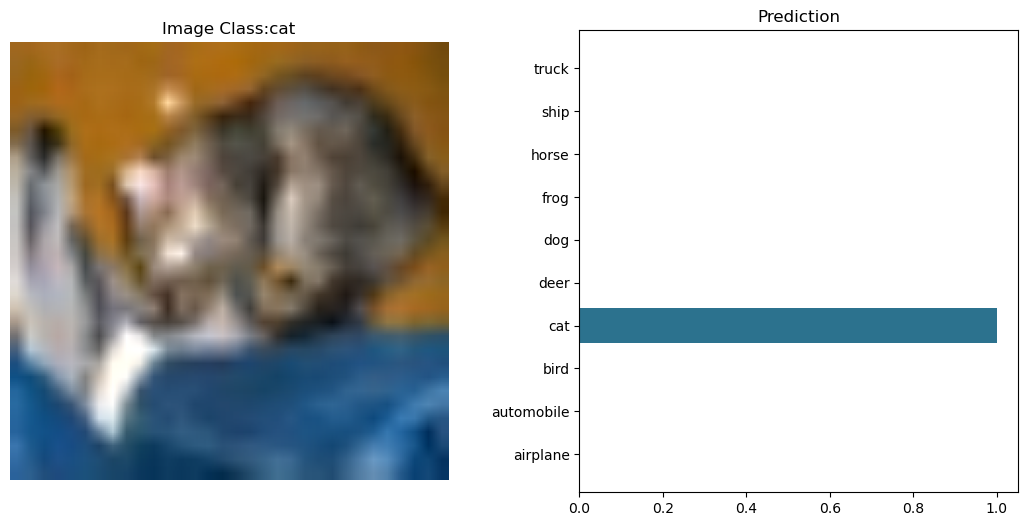

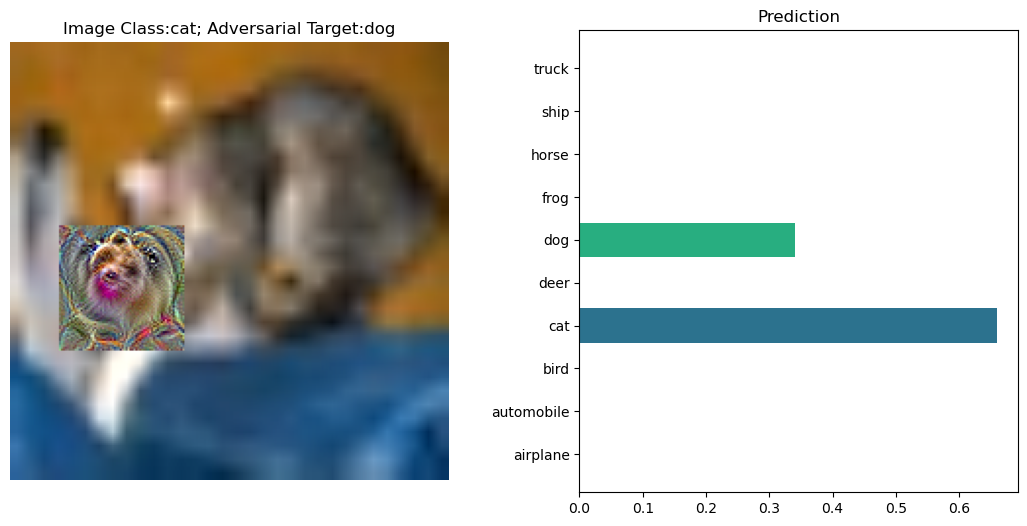

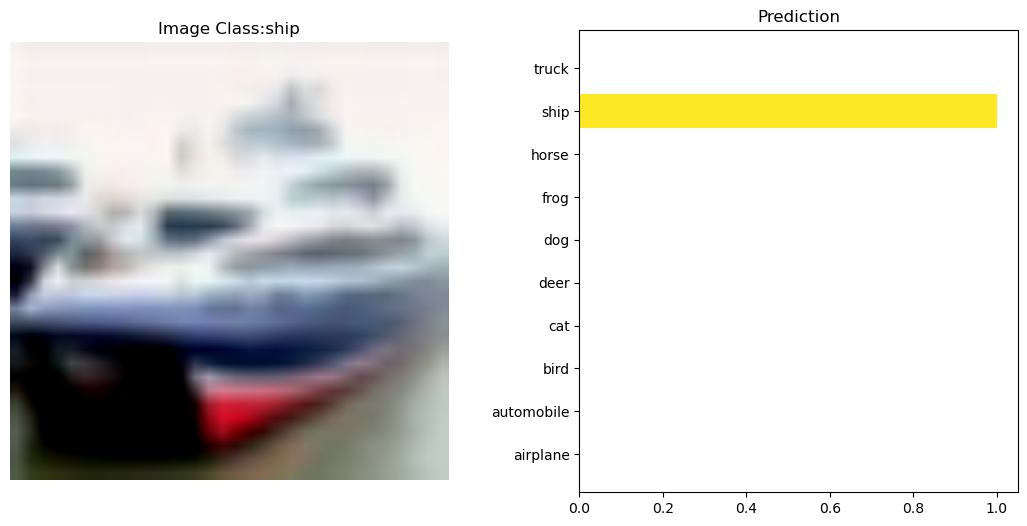

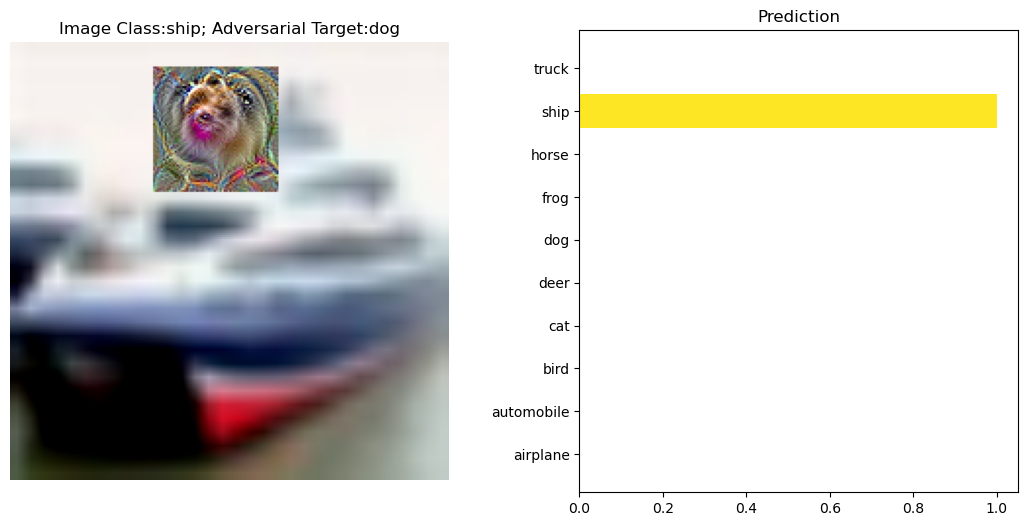

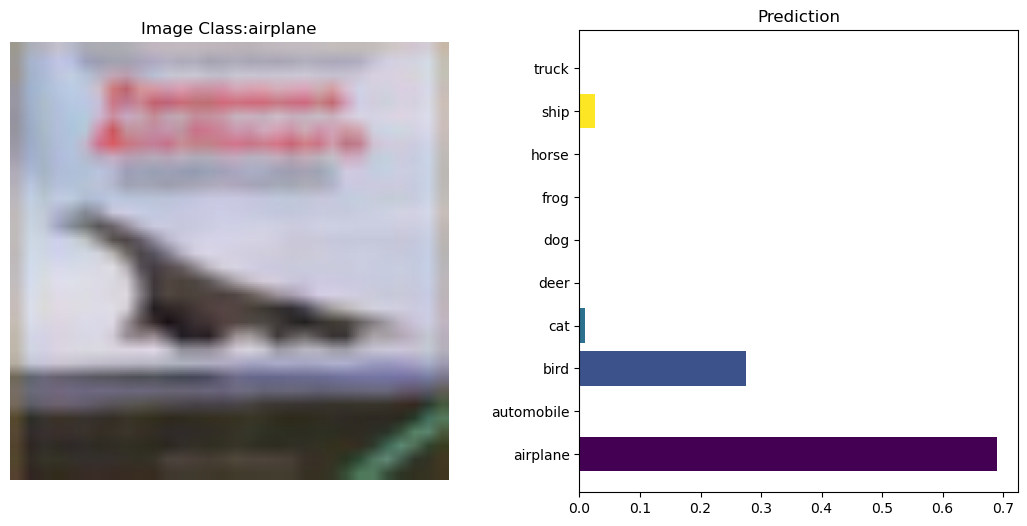

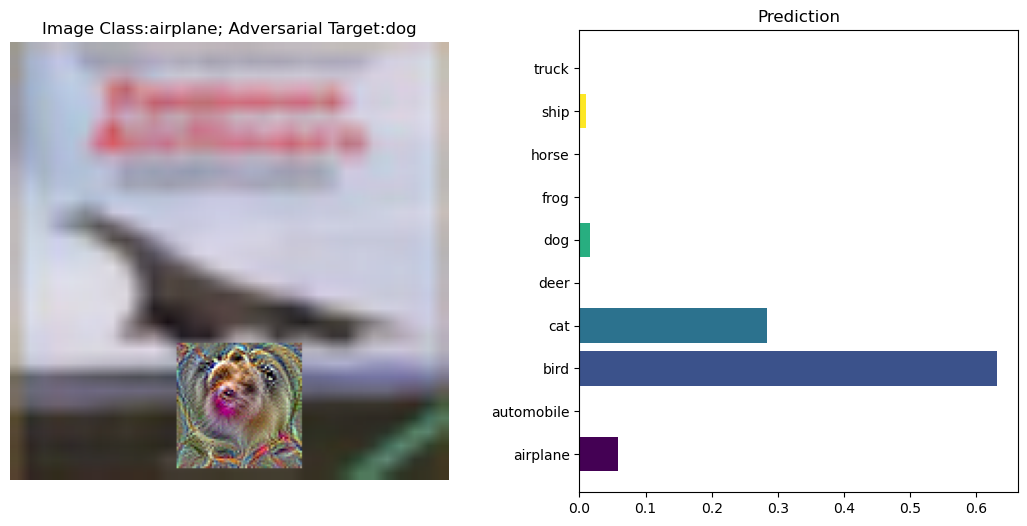

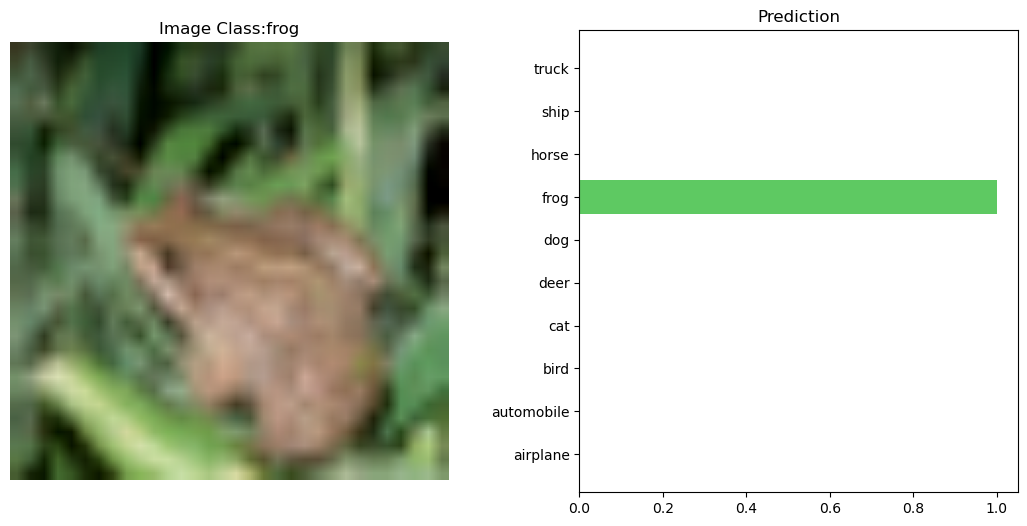

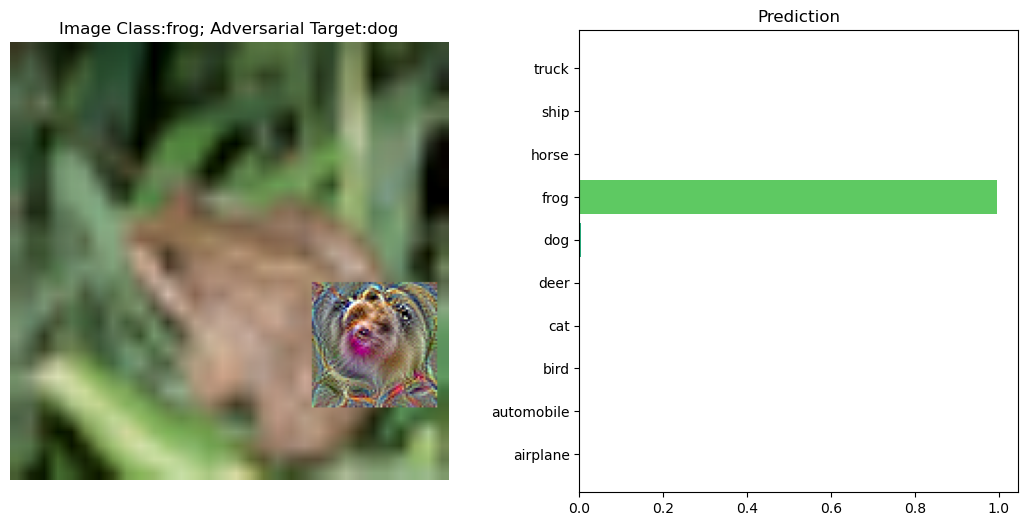

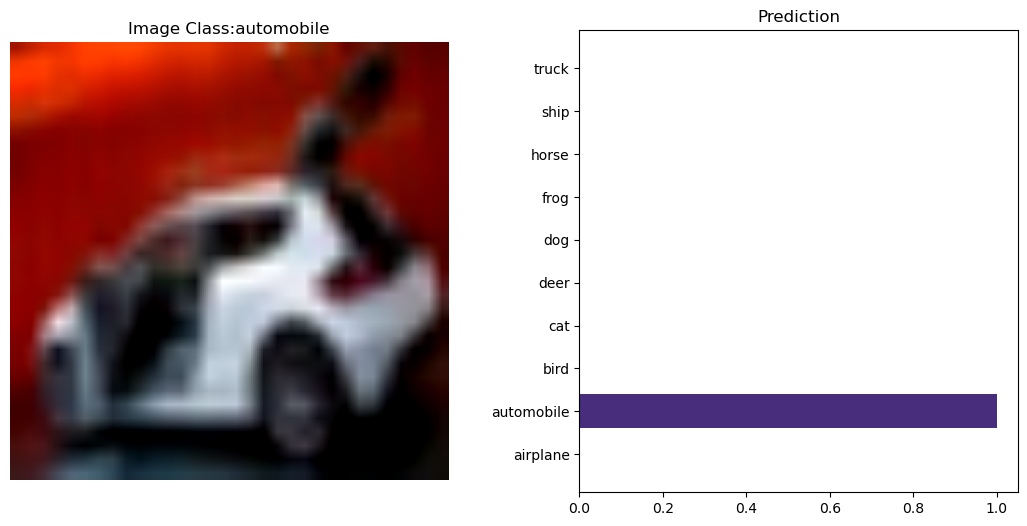

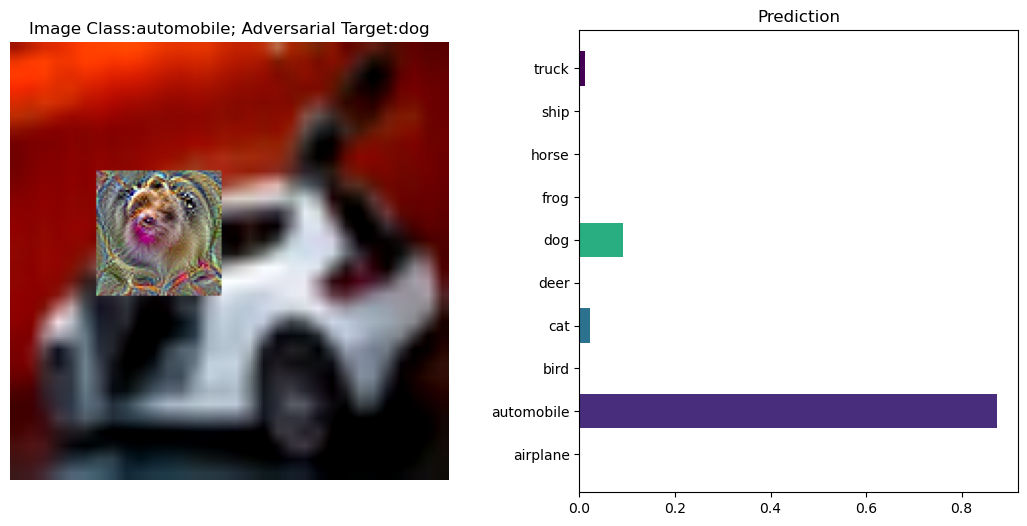

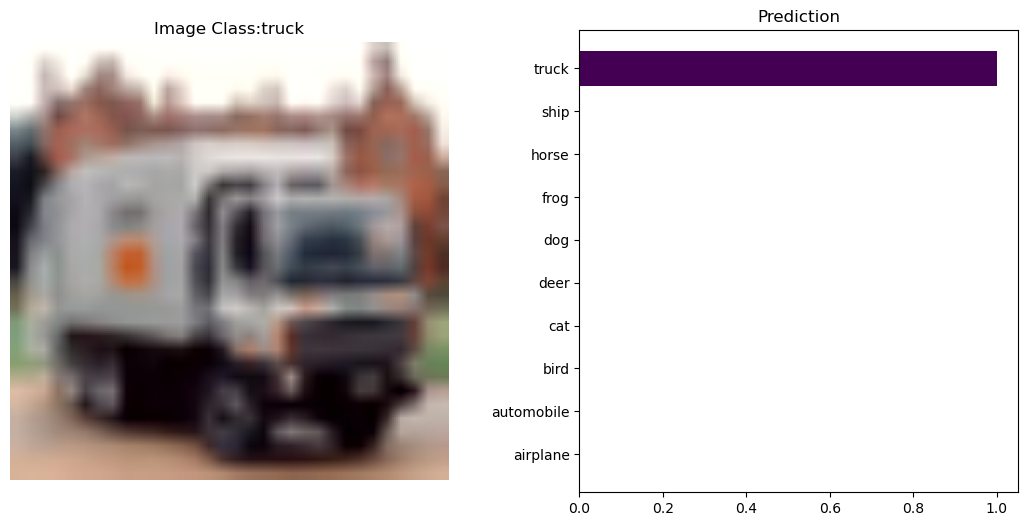

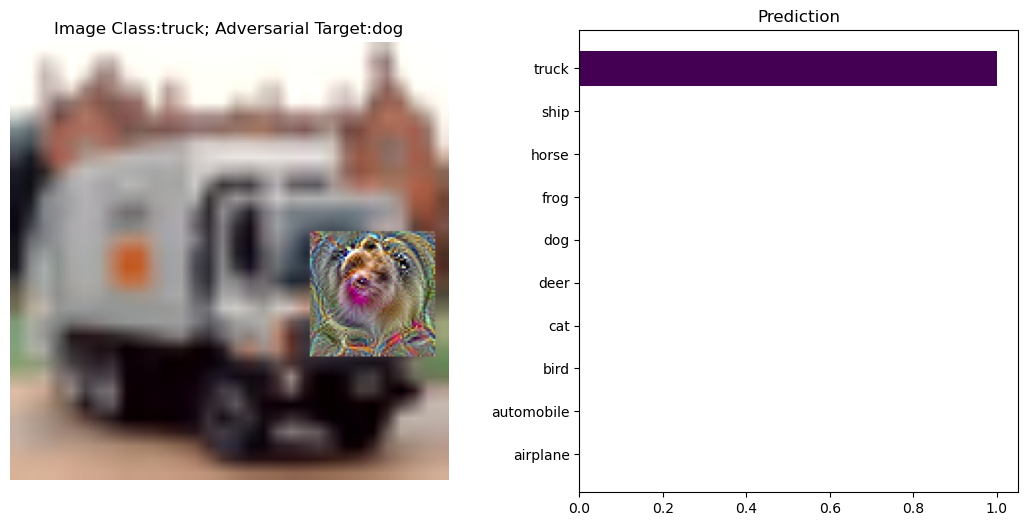

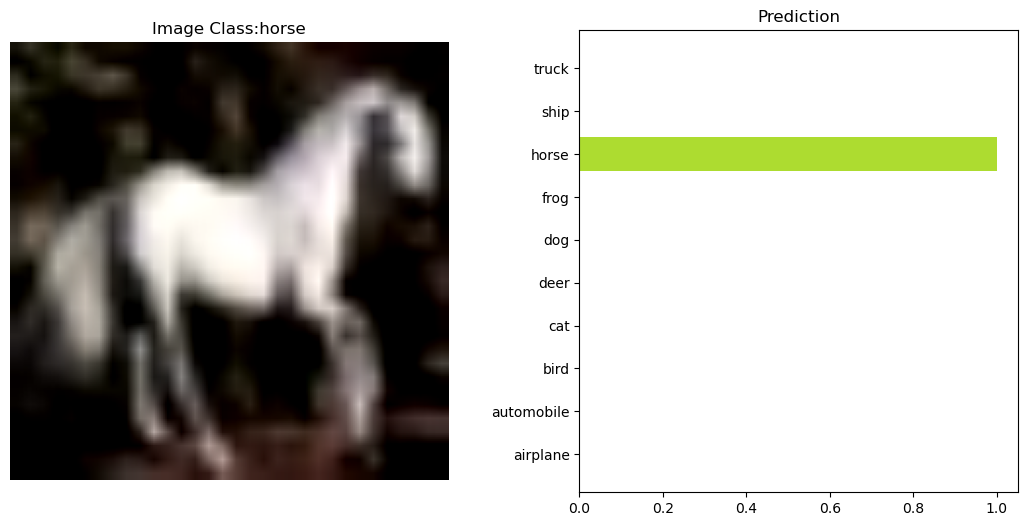

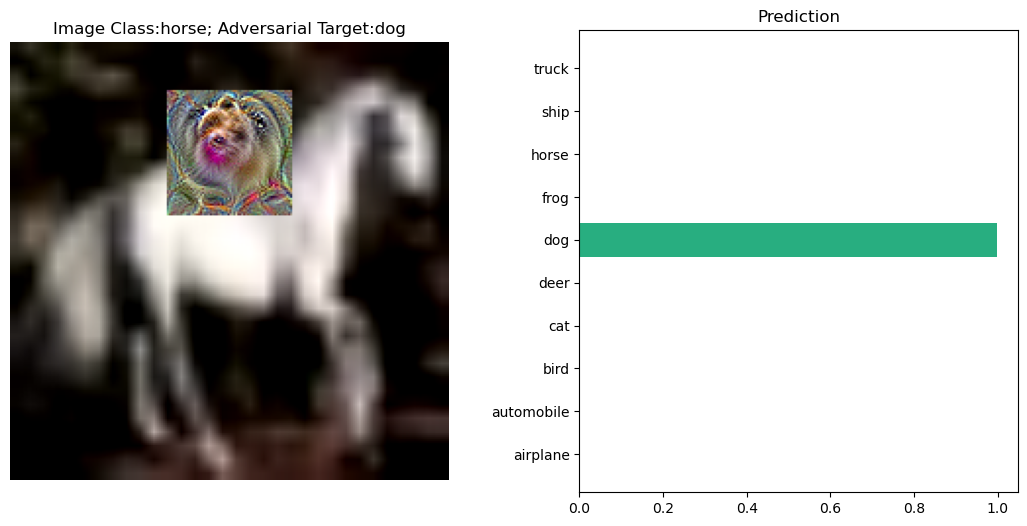

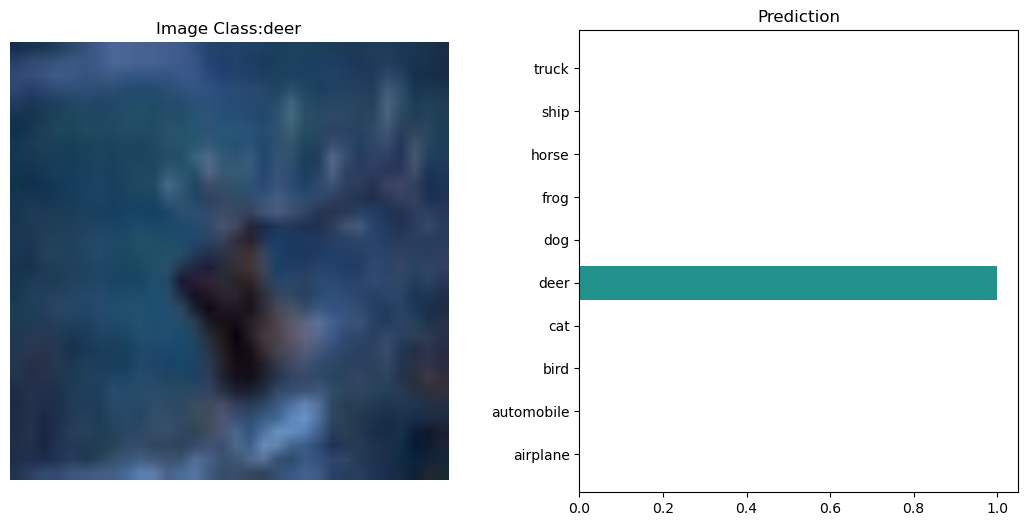

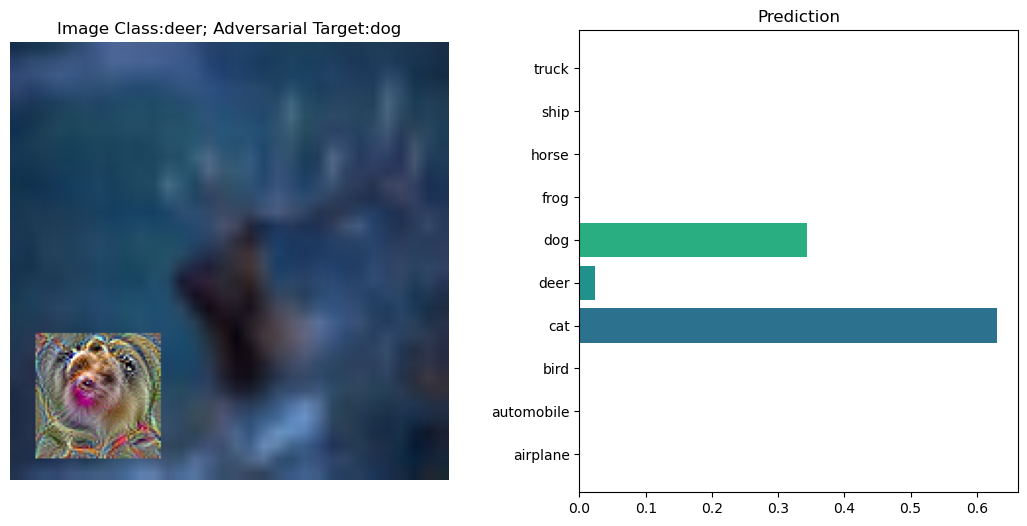

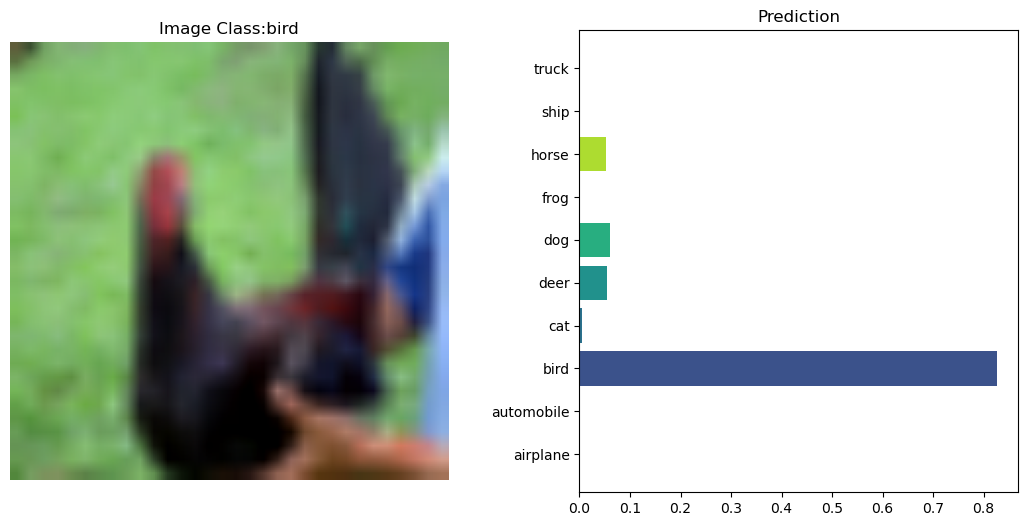

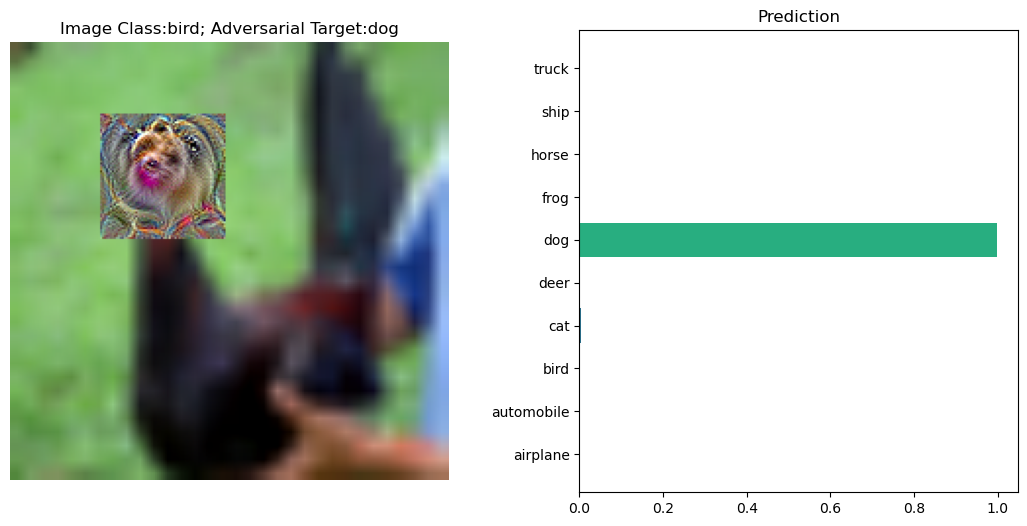

In [31]:
import matplotlib.cm as cm
import os

img_classes = []

# Classes in CIFAR10 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck'

# Load the patch
target_text = 'dog'
target_class = torch.tensor([dataset.classes.index(target_text)]).to(device)
patch_size = 64
final_patch_tensor = torch.from_numpy(np.load(f'patches/adv_patch_{target_text}_{patch_size}.npy')).to(device)

# Load image classifier
num_classes = 10  # Number of classes in CIFAR-10

# ResNet-50 model
# model = models.resnet50(pretrained=True)  # Initialize ResNet-50 model
# model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)  # Modify output layer to match number of classes
# model = model.to(device)
# model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'resnet50_.pth'))['state_dict']) 

# VGG16
model = models.vgg16(pretrained = True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features,num_classes)
model = model.to(device)
model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'vgg16_.pth'))['state_dict']) 


# DenseNet model
# model = models.densenet121(pretrained=True)
# model.classifier = nn.Linear(model.classifier.in_features, num_classes)
# model = model.to(device)
# model.load_state_dict(torch.load(os.path.join(CHECKPOINT_FOLDER, 'densenet_.pth'))['state_dict']) 

model.eval()

for i, (img, target) in enumerate(test_loader): 
    if (target.item() not in img_classes) and (target != dataset.classes.index(target_text)):
        img_classes.append(target)
        # Move data to gpu
        img = img.to(device)
        target = target.to(device)
        with torch.no_grad():
            # Get prediction of unpatched image
            img_clean = img.clone()
            img_clean= img_clean.to(device)
            out = model(img_clean)
            _, pred_class_clean = out.max(1)

            # Visualize prediction
            # Plot original image and prediction
            plt.figure(figsize=(13, 6))

            # Plot original image
            plt.subplot(1, 2, 1)
            plt.imshow(np.clip(np.transpose(img.detach().cpu().numpy().squeeze(0), (1, 2, 0))*data_std_np + data_mean_np, 0, 1))
            plt.title(f"Image Class:{dataset.classes[target.item()]}")
            plt.axis('off')

            # Plot prediction
            plt.subplot(1, 2, 2)
            colors = cm.viridis(np.linspace(0, 1, 9))
            plt.barh(dataset.classes, torch.softmax(out, dim=-1).detach().cpu().numpy().squeeze(0), color=colors)
            plt.title("Prediction")
            plt.subplots_adjust(wspace=0.3)
            plt.savefig(f'clean_{dataset.classes[target.item()]}.png', bbox_inches='tight', dpi=300)
            plt.show()
            
            # Only apply patches on images that not in target class
            # Skip images that are predicted incorrectly into target class
            if target != target_class and pred_class_clean != target_class:
                # Get patched prediction
                patched_img = img.clone()
                location = (random.randint(0, patched_img.shape[2] - patch_size), random.randint(0, patched_img.shape[3] - patch_size))
                patched_img = apply_patch(patched_img, final_patch_tensor, patch_size, location).to(device)
                out_patched = model(patched_img)
                
                # Plot patched image and prediction
                plt.figure(figsize=(13, 6))

                # Plot original image
                plt.subplot(1, 2, 1)
                plt.imshow(np.clip(np.transpose(patched_img.detach().cpu().numpy().squeeze(0), (1, 2, 0))*data_std_np + data_mean_np, 0, 1))
                plt.title(f"Image Class:{dataset.classes[target.item()]}; Adversarial Target:{dataset.classes[target_class.item()]}")
                plt.axis('off')

                # Plot prediction
                plt.subplot(1, 2, 2)
                plt.barh(dataset.classes, torch.softmax(out_patched, dim=-1).detach().cpu().numpy().squeeze(0), color=colors)
                plt.title("Prediction")
                plt.subplots_adjust(wspace=0.3)
                plt.savefig(f'adv_{dataset.classes[target.item()]}_with_{dataset.classes[target_class.item()]}.png', bbox_inches='tight', dpi=300)
                plt.show()
                
    elif len(img_classes)==9:
        break
    else:
        pass

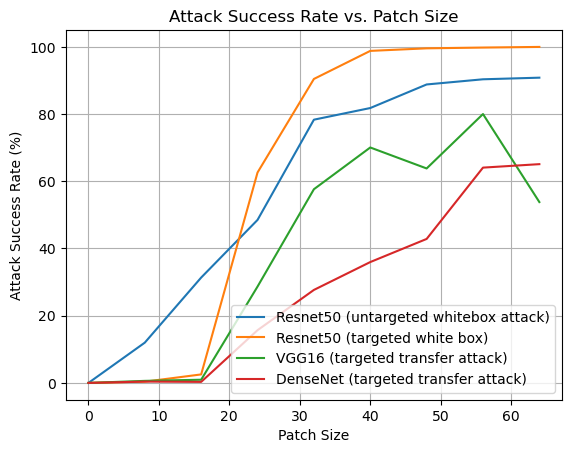

In [30]:
# Define the data
model_names = ["Resnet50 (untargeted whitebox attack)", "Resnet50 (targeted white box)", "VGG16 (targeted transfer attack)", "DenseNet (targeted transfer attack)"]
patch_sizes = [0, 8, 16, 24, 32, 40, 48, 56, 64]

# ASR data for each model and patch size
asr_data = {
    "Resnet50 (untargeted whitebox attack)": [0, 11.99, 31.35, 48.50, 78.32, 81.79, 88.80, 90.34, 90.82],
    "Resnet50 (targeted white box)": [0, 0.37, 2.53, 62.61, 90.44, 98.79, 99.55, 99.78, 99.97],
    "VGG16 (targeted transfer attack)": [0, 0.61, 0.95, 28.67, 57.63, 70.05, 63.81, 80.00, 53.81],
    "DenseNet (targeted transfer attack)": [0, 0.40, 0.31, 15.69, 27.67, 35.96, 42.84, 64.06, 65.09],
}

# Plot ASR vs. Patch Size for each model
for model in model_names:
    asr_values = asr_data[model]
    plt.plot(patch_sizes, asr_values, label=model)

# Customize the plot
plt.xlabel('Patch Size')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate vs. Patch Size')
plt.legend()

# Show the plot
plt.grid()
plt.show()


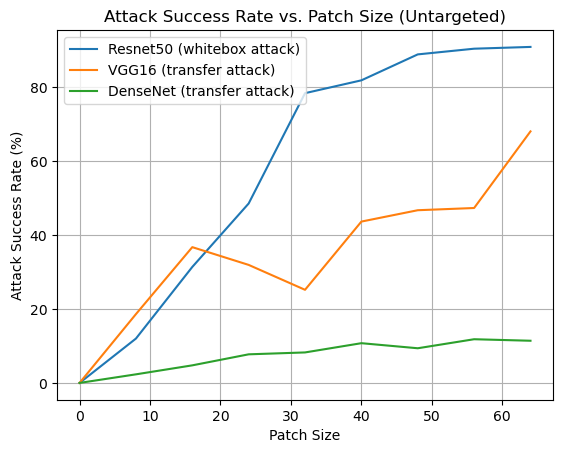

In [36]:
# Define the data
model_names = ["Resnet50 (whitebox attack)", "VGG16 (transfer attack)", "DenseNet (transfer attack)"]
patch_sizes = [0, 8, 16, 24, 32, 40, 48, 56, 64]

# ASR data for each model and patch size
asr_data = {
    "Resnet50 (whitebox attack)": [0, 11.99, 31.35, 48.50, 78.32, 81.79, 88.80, 90.34, 90.82],
    "VGG16 (transfer attack)": [0, 18.60, 36.70, 31.90, 25.17, 43.61, 46.68, 47.28,  67.99],
    "DenseNet (transfer attack)": [0, 2.32, 4.75, 7.73, 8.24, 10.74, 9.37, 11.81, 11.40],
}

# Plot ASR vs. Patch Size for each model
for model in model_names:
    asr_values = asr_data[model]
    plt.plot(patch_sizes, asr_values, label=model)

# Customize the plot
plt.xlabel('Patch Size')
plt.ylabel('Attack Success Rate (%)')
plt.title('Attack Success Rate vs. Patch Size (Untargeted)')
plt.legend()

# Show the plot
plt.grid()
plt.show()